## Housing Prices in Stockholm 

Stockholm is a popular and sought after city to live in Sweden. The project analyzes data scraped from Sweden most popular listing sites 'Hemnet.se' and build an ML model that can predict apartment prices based on a number of features. 

Machine learning housing pricing models work by using historical data from the past, apply predictive analytics models, and then predict future housing prices.

### Project Goals

1. To acquire real-world housing market data that is available online by collecting or scraping listings.


2. clean and filter the collected dataset in order to make it available for further data analysis and insight. 


3. Build pricing / valuation Machine learning model that can reasonably estimate property values based on relevant features such as size, number of rooms, and location,distance from the city centre. It makes a reasonable estimate on its sale-price with a feasible accuracy such that it would actually be considered useful.


4. Get insight about the housing market in Stockholm. Hopefully the insights from the project will be  able to support me in decision making when I consider buying apartments.


### Workflow

1. Data collection : acquire data by webscraping Sweden's largest listings site 'Hemnet.se'.

2. Data Cleaning : clean, create new features , and transform the scraped dataset  in to an analysis ready format.
    
3. Explore and visualize the data to uncover patterns and anomalies.

4. Build predictive models using machine learning algorithms.

5. Present the findings through Tableau dashboard.

In [2]:
import numpy as np   
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import pickle
import joblib
import warnings
warnings.filterwarnings("ignore")

In [12]:
df_sthlm=pd.read_csv('result_ml.csv')

In [13]:
df_sthlm.shape

(10336, 18)

In [14]:
df_sthlm.columns

Index(['Address', 'Amt per m²', 'Balcony', 'District', 'Elevator', 'Floor',
       'Location', 'Monthly Pay', 'Municipality', 'Patio', 'Price',
       'Size in m²', 'Total Rooms', 'Latitude', 'Longitude', 'lat_2', 'long_2',
       'Distance'],
      dtype='object')

In [15]:
df_sthlm.drop(columns=['Address','Location','District','lat_2', 'long_2','Latitude',
       'Longitude'],axis=1,inplace=True)

##### Check if there is any missing values in any of the columns

In [10]:
df_sthlm.isna().sum()

Amt per m²      0
Balcony         0
Elevator        0
Floor           0
Monthly Pay     0
Municipality    0
Patio           0
Price           0
Size in m²      0
Total Rooms     0
Distance        0
dtype: int64

No missing values in any of the columns.

#### Data Pre-Processing

Categorize the columns based on their data types as object, integer or float.

some machine learning algorithms require numeric input. Therefore, we need to convert categorical features to numeric before feeding them into our models.

In [16]:
categorical_cols = ['Balcony', 'Patio', 'Elevator']
df_sthlm[categorical_cols] = df_sthlm[categorical_cols].apply(lambda col: col.astype('category').cat.codes)

Label encoding is used to encode categorical columns with more than two categories

In [17]:
le=LabelEncoder()
df_sthlm['Municipality']=le.fit_transform(df_sthlm['Municipality'])

#### Feature Selection

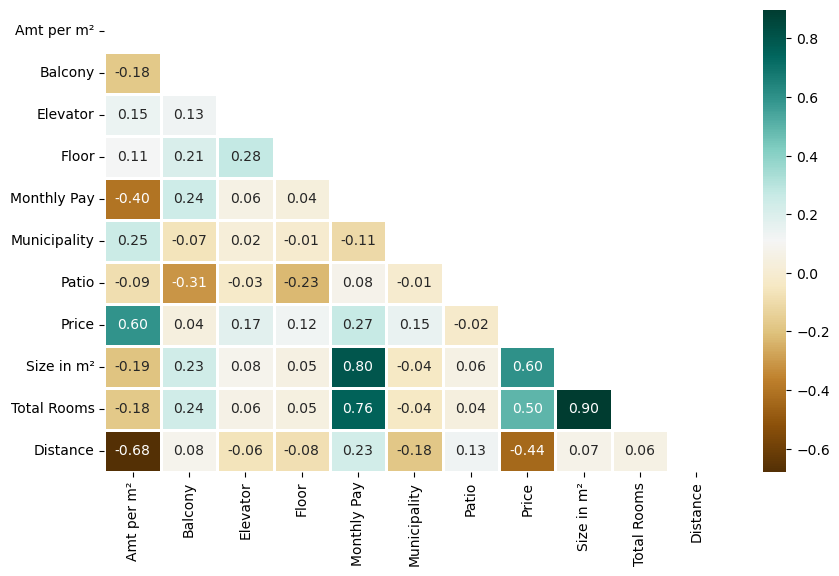

In [18]:
mask = np.triu(np.ones_like(df_sthlm.corr(), dtype=bool))
plt.figure(figsize=(10,6)) 
sns.heatmap(df_sthlm.corr(),
            mask=mask,
            cmap='BrBG',
            fmt='.2f',
            linewidths=2,
            annot=True)

plt.show()

it is clear that the features ‘Size in m²’, ‘Total Rooms,’  and ‘Amt per m²’ show a better correlation with the target target column ‘Price’ which is a good indicator for using these features as predictors. 


But also there is a high correlation between the features ‘Monthly Pay’ and ‘Size in m²’ and so ‘Monthly Pay’ is dropped .

The column 'Patio' was also removed as it doesn't show any correlation with the price

In [19]:
df_sthlm.drop(columns=['Monthly Pay','Patio'],axis=1,inplace=True)

##### Data Modeling

In [20]:
X=df_sthlm.drop(['Price'],axis=1)
y=df_sthlm['Price']

Let's the relationship between the predictors and the target feature.

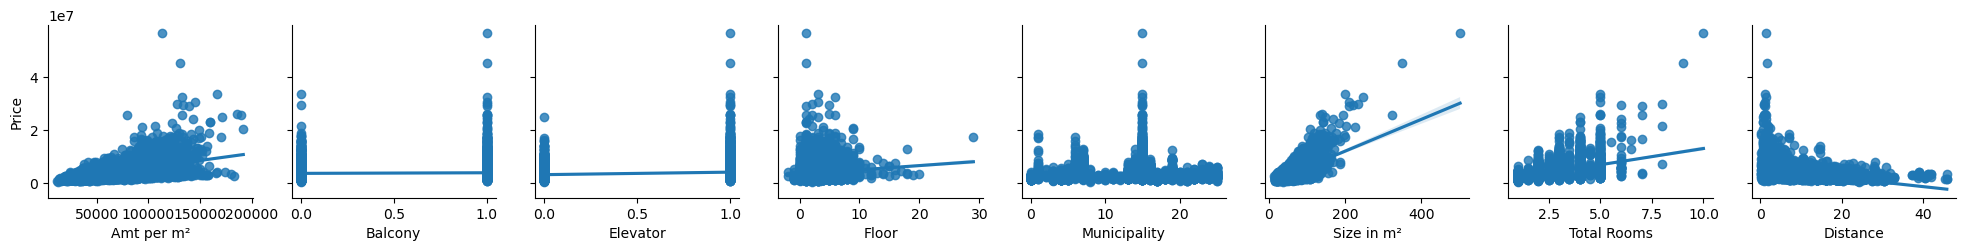

In [21]:
sns.pairplot(df_sthlm, 
             x_vars=X.columns, 
             y_vars='Price',
             diag_kind='hist',
             kind='reg')

Split the dataset in to training and testing set.

In [22]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

##### Scaling

Scaling the data is often a necessary step in machine learning because it can help to ensure that all of the features are on the same scale, which can improve the performance of some models.

In [23]:
scaler=StandardScaler() 
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)  
X_test_scaled=scaler.transform(X_test)

### Building ML Model

The project have demonstrated how to use machine learning techniques to predict house prices in Stockholm. The project started by exploring the data and identifying potential features that could influence house prices. We then used these features to train a lasso regression model, a Ridge regression model, a random forest model, and an XGBoost model. Hyperparameter tuning using both grid as well as randomsearch was to improve the performance of the models.

In [24]:
#Initialize the four models Linear Regression,, Ridge Regression,XGBoost, Random Forest for comparison. 
lr=LinearRegression()
model_xgb = XGBRegressor()
# Define the hyperparameter grid
param_grid = {'max_depth': [3, 5, 7],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [100, 200, 300],
              'reg_lambda': [0.1, 1.0, 10.0]}
              
# Use grid search to tune the hyperparameters              
xgb = GridSearchCV(model_xgb, param_grid, cv=5)  

 #fitting the model
xgb.fit(X_train_scaled, y_train) 
model_rf = RandomForestRegressor()
param_distributions = {'n_estimators': [10, 100],   
                       'max_depth': [None, 3, 5,],
                       'min_samples_split': [2, 5],
                       'min_samples_leaf': [1, 2]}
                       
# Use RandomizedSearchCV to tune the hyperparameters
rf = RandomizedSearchCV(model_rf, param_distributions, n_iter=10, cv=5)  

#fitting the model with the tuned parameters
rf.fit(X_train_scaled, y_train)  
ridge= Ridge()
# The 'algorithms' dictionary stores four machine learning models for comparison, where the keys are the model names ('Linear Regression', 'XGBoost','Random Forest' and 'Ridge Regression') and the values are the corresponding model instances.

algorithms = { 
            'Linear Regression':lr,
            'XGBoost': xgb,
            'Random Forest': rf,
            'Ridge Regression': ridge
            }

In [25]:
# Initialize empty dictionaries to store RMSE and R-squared scores for each algorithm
rmse_scores, r2_scores = {}, {}

# Loop through the 'algorithms' dictionary
for algorithm, model in algorithms.items():
    # Train the current model (model) using the training data (Xtrain and ytrain).
    model.fit(X_train_scaled, y_train)
    # Make predictions on the test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate and store the RMSE and R-squared scores for the current algorithm
    rmse_scores[algorithm] = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_scores[algorithm] = r2_score(y_test, y_pred)

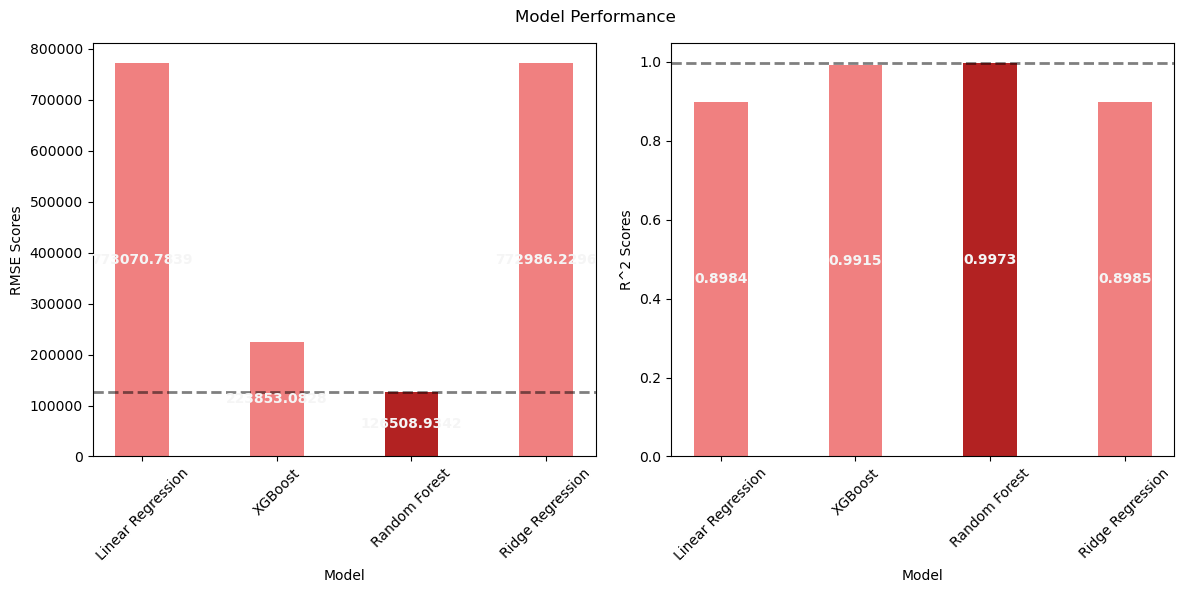

In [26]:
def plot_model_performance(rmse_scores, r2_scores):
    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Define the indices and bar width
    ind = np.arange(len(rmse_scores))
    width = 0.4

    # Plotting settings for RMSE and R^2 Scores
    score_dicts = [rmse_scores, r2_scores]
    y_labels = ['RMSE Scores', 'R^2 Scores']
    
    for i, (score_dict, y_label) in enumerate(zip(score_dicts, y_labels)):
        scores = list(score_dict.values())
        
        # Create bar plots
        bars = ax[i].bar(ind, scores, width, color="lightcoral")
        ax[i].bar_label(bars, fmt='%.4f', weight='bold', label_type='center', color='whitesmoke')
        
        # Highlight the best score
        best_score_idx = scores.index(min(scores) if i == 0 else max(scores))
        ax[i].patches[best_score_idx].set_facecolor('firebrick')
        
        # Add a dashed line for the best score
        best_score = min(scores) if i == 0 else max(scores)
        ax[i].axhline(best_score, ls="--", alpha=0.5, color="black", lw=2)
        
        # Set x-ticks, labels, and title
        ax[i].set_xticks(ind)
        ax[i].set_xticklabels(score_dict.keys(), fontsize=10, rotation=45)
        ax[i].set_xlabel("Model", fontsize=10)
        ax[i].set_ylabel(y_label, fontsize=10)
    
    # Set the overall title
    fig.suptitle("Model Performance", fontsize=12)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_model_performance(rmse_scores, r2_scores);

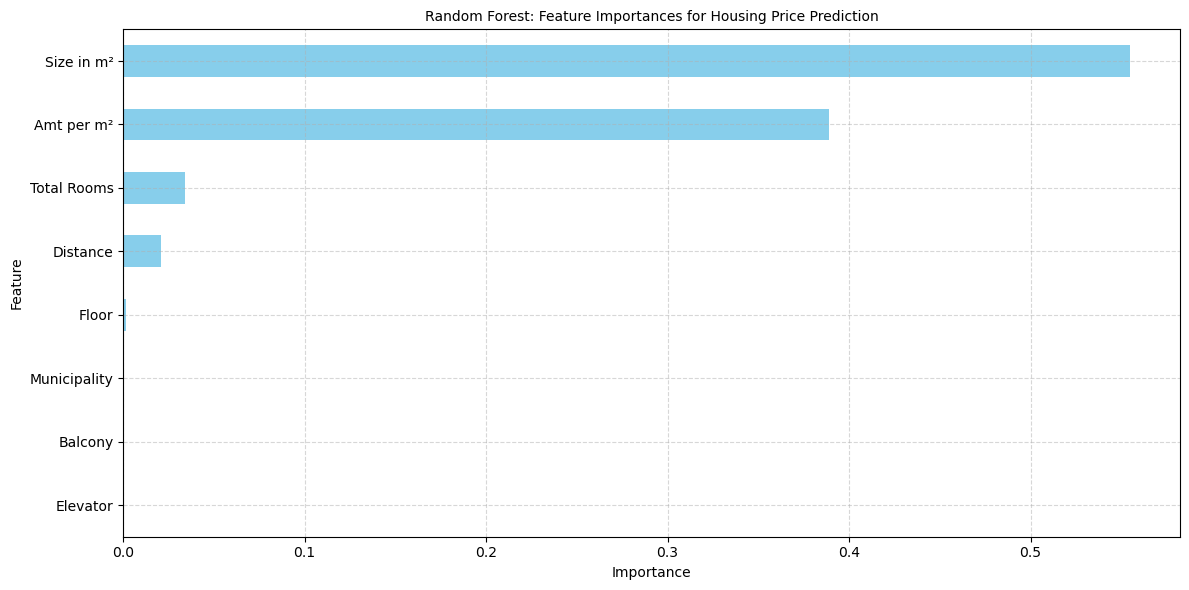

In [27]:
# Create a Pandas Series to store feature importances from the model
feature_rank=pd.Series(rf.best_estimator_.feature_importances_,index=X_train.columns,name='Importance').sort_values(ascending=True,inplace=False) 

# Plotting a horizontal bar chart to visualize feature importances
ax=feature_rank.plot(kind='barh',figsize=(12,6), color='skyblue')

# Setting x-axis and y-axis labels, and the title for the plot
plt.xlabel("Importance", fontsize=10)
plt.ylabel("Feature", fontsize=10)
plt.title("Random Forest: Feature Importances for Housing Price Prediction", fontsize=10)

#add line grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show();

In [28]:
# Save the model to a file
joblib.dump(rf, 'rf_model_full.joblib')

['rf_model_full.joblib']

In [29]:
# Load the model using Joblib
loaded_model_joblib = joblib.load('rf_model_full.joblib')

### Conclusion and Recommendation

The project demonstrated how to use machine learning techniques to predict apartment prices in Stockholm. It started by collecting listings information from **Hemnet.se** and **Booli.se** , clean,explore and transform the dataset and identifying potential features that could influence house prices. Some features were selected and used to train different models such as a linear regression model, a Ridge regression model, a random forest model, and an XGBoost model. hyperparameter tuning using GridSearchCV as well as RandomSearchCV was used to improve the performance of the models.

It was found that all of the models performed well, with the random forest model having the best test set performance. However, it is important to note that the results of this analysis are dependent on the choice of features and the specific data used. Different data or a different set of features could lead to different conclusions. 

The five most important features in predicting housing prices were: **The size** of the apartment ,**the square meter price** of the apartment, **the number of rooms** it has  , **Floor** as well as **the distance** to the city centre. These variables are most helpful in predicting the outcome variable, 'Price of an apartment'.

As expected newly constructed apartments had much higher prices per m².

Lidingö,Danderyds, Nacka, Solna and Stockholm Municipalities have the most expensive apartments in terms of price or square metre price.

As expected the most expensive areas in Stockholm on Price per m² are: Kungsholmen,Vasastan/Hagastaden, Ostermalm and Sodermalm.

Buyers with a limited budget can find cheaper apartments in Södertälje, Botkyrka, Nynäshamns, Nykvarns, and Signtuna Municipalities.

The apartments with the highest prices were mostly located in the Stockholm city centre.

In [32]:
X_train.columns

Index(['Amt per m²', 'Balcony', 'Elevator', 'Floor', 'Municipality',
       'Size in m²', 'Total Rooms', 'Distance'],
      dtype='object')